# Installing Debezium for CDC
---

You need to 
1. download the Debezium Connector https://debezium.io/releases/2.6/
2. Scrow Down To Downloads
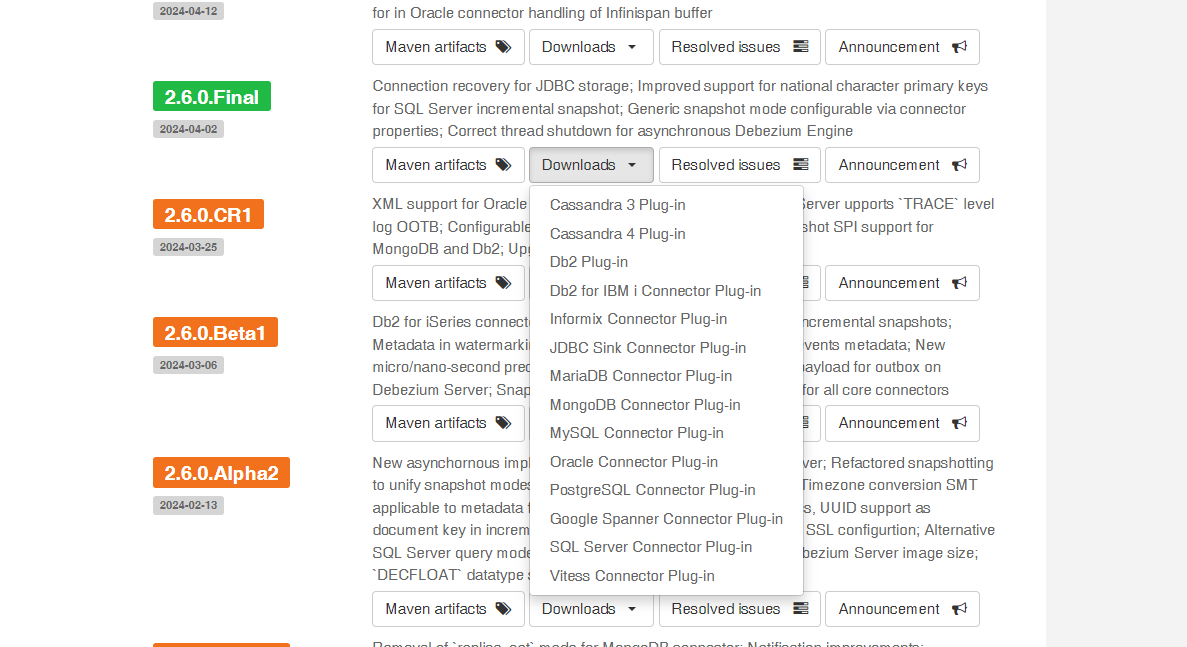

>once downloaded

1. Create a folder inside `confluent-7.6.1/` called `connectors`
2. UnTAR the connector inside this folder `cd connectors/` and `tar -xvzf debezium-connector-sqlserver-XXX`
3. 

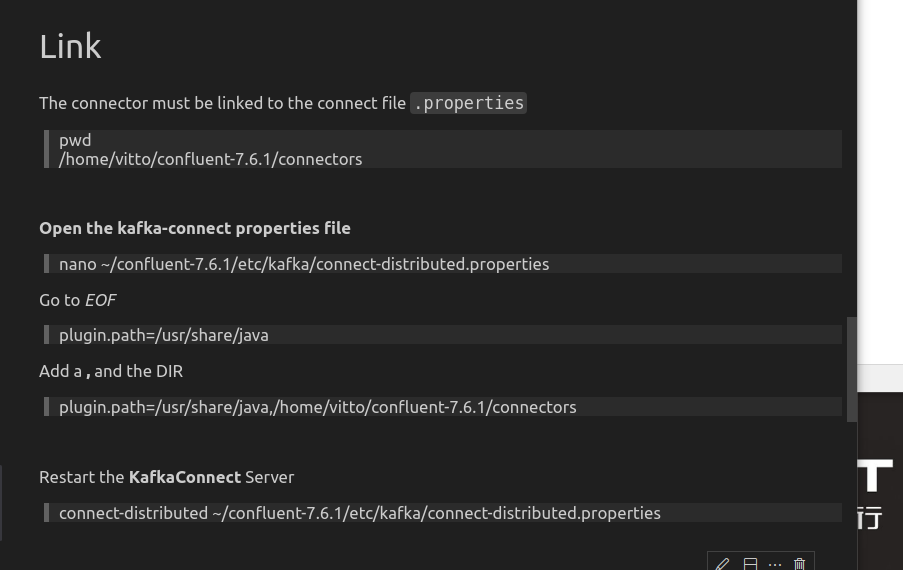

## Kafka Connect 
Lives in the port 8083, contains all the connectors

### Did it worked?

|||
|---|---|
|http://localhost:8083/connector-plugins| 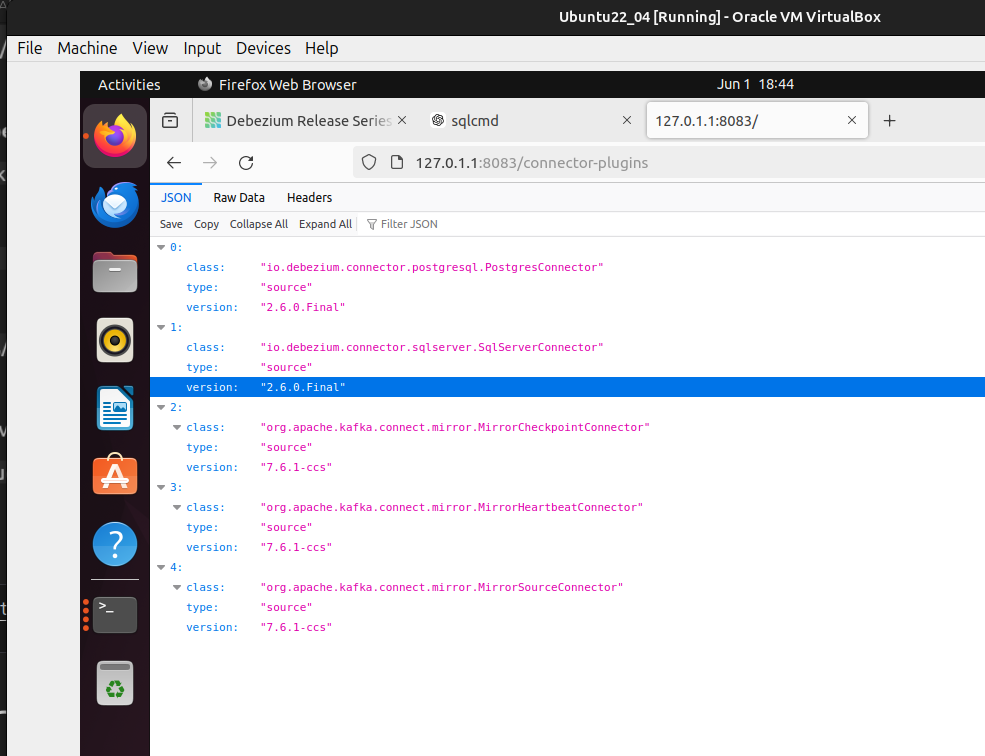|

# Enabling CDC on SQL Server DB
---
https://debezium.io/documentation/reference/stable/connectors/sqlserver.html#setting-up-sqlserver

Prerequisites
* You are a member of the sysadmin fixed server role for the SQL Server.
* You are a db_owner of the database.
* The SQL Server Agent is running.

In the ubuntu Terminal
```sh
    sudo /opt/mssql/bin/mssql-conf set sqlagent.enabled true
```
Restart SQL Server
```sh
    sudo systemctl restart mssql-server.service
```

In order to use `CDC` you have to enable it, for that you need to run the Store Procedure
1. At a DataBase Level
2. At a Table Level

In [ ]:
USE YourSelectedDB
GO
EXEC sys.sp_cdc_enable_db
GO

This will enable `CDC`, to see if it worked, look at the tables, you should have 5 new tables <br>
Look this example
|Before|After| 
|---|----|
|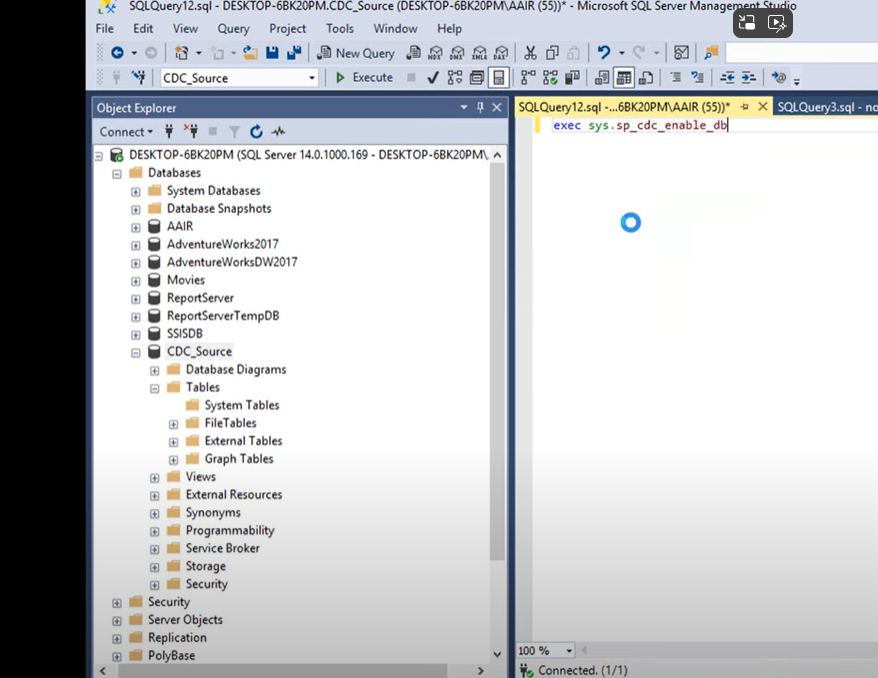|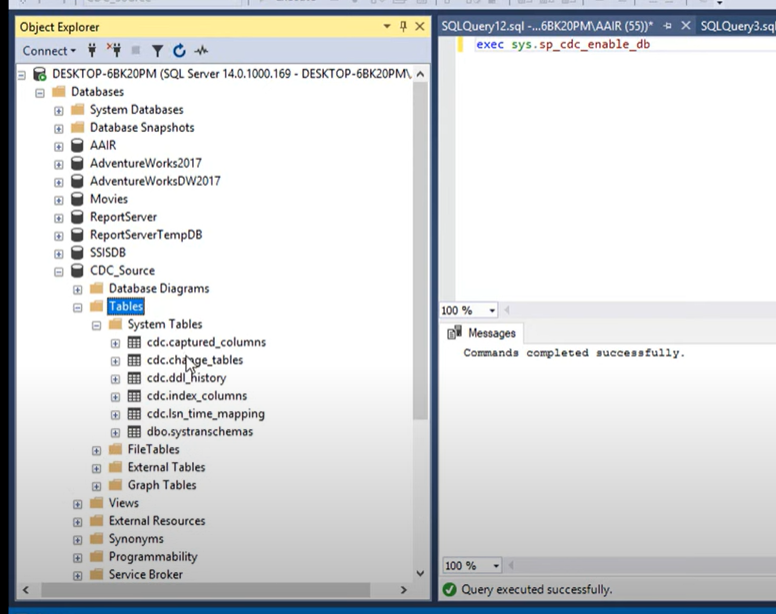|

> After CDC is applied, it captures all of the INSERT, UPDATE, and DELETE operations that are committed to the tables for which CDC is enabled. The Debezium connector can then capture these events and emit them to Kafka topics

Now you have to enable CDN over a table
|Before|After|
|---|---|
|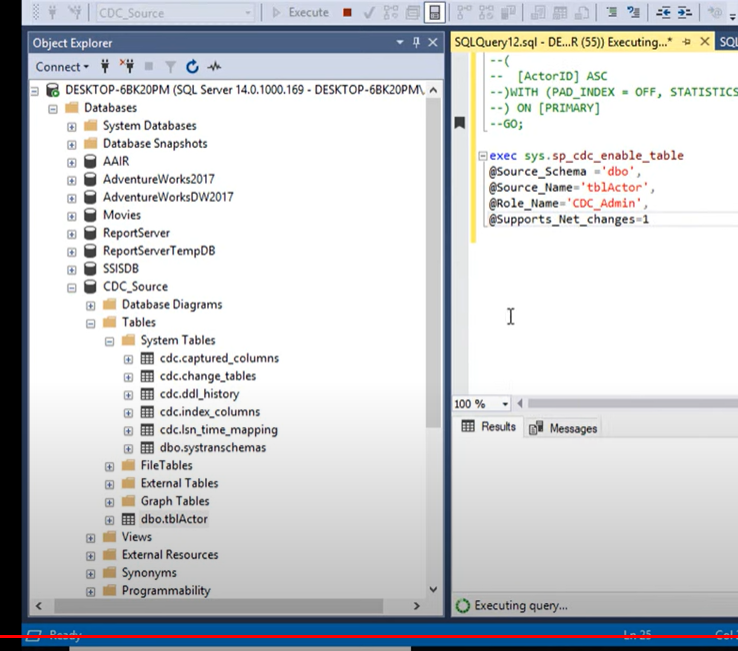|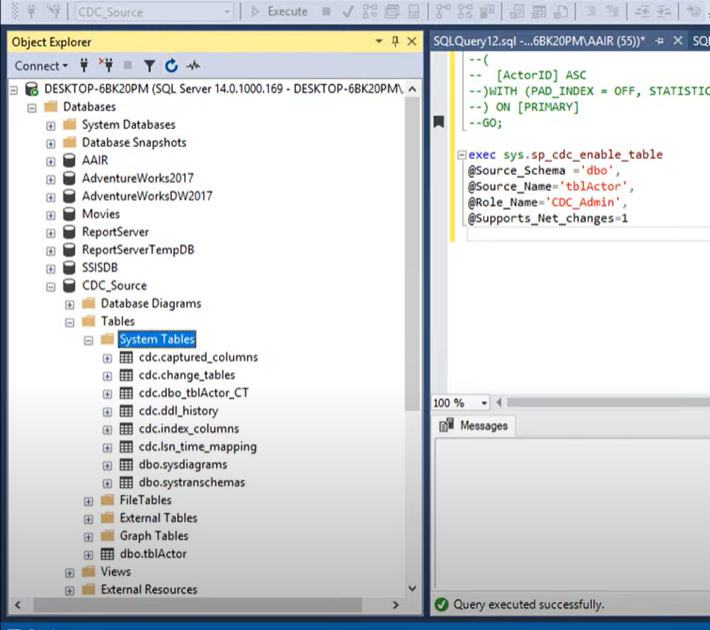|

**Full From Debezium Doc**
```sql
    USE MyDB
    GO
    
    EXEC sys.sp_cdc_enable_table
    @source_schema = N'dbo',        -- The schema of the source table
    @source_name   = N'MyTable',    -- The name of the source table
    @role_name     = NULL,     -- The name of the database role used to control access to the change data
    [@filegroup_name = N'MyDB_CT',]   -- The filegroup where the change data capture change tables will be created
    @supports_net_changes = 1       -- Specifies that net changes are not supported
    GO
``` 

1. **source_name:** Specifies the name of the table that you want to capture.
Specifies a role MyRole to which you can add users to whom you want to grant SELECT permission on the captured columns of the source table. 
2. **role_name:** Users in the sysadmin or db_owner role also have access to the specified change tables. Set the value of @role_name to NULL, to allow only members in the sysadmin or db_owner to have full access to captured information.
3. **filegroup_name:** Specifies the filegroup where SQL Server places the change table for the captured table. The named *filegroup must already exist*. It is best not to locate change tables in the same filegroup that you use for source tables.
4. **supports_net_changes:** When this parameter is set to 1 (true), it allows the capture of net changes, which means you can get a summarized view of the changes that have occurred over a period, showing only the final state of each row after all changes are applied. When it is set to 0 (false), only the detailed changes (insert, update, delete) are captured and net changes queries are not supported

### Did it worked?
besides the consult of the tables (which is more difficult when using `sqlcmd`)
you can use 
```sql
USE MyDB
GO
EXEC sys.sp_cdc_help_change_data_capture
GO
```

> The query returns configuration information for each table in the database that is enabled for CDC and that contains change data that the caller is authorized to access. If the result is empty, verify that the user has privileges to access both the capture instance and the CDC tables.


## SQL Server connector configuration example
Following is an example of the configuration for a connector instance that captures data from a SQL Server server at port 1433 on 192.168.99.100, which we logically name fullfillment. Typically, you configure the Debezium SQL Server connector in a JSON file by setting the configuration properties that are available for the connector.

You can choose to produce events for a subset of the schemas and tables in a database. Optionally, you can ignore, mask, or truncate columns that contain sensitive data, that are larger than a specified size, or that you do not need.

```json
{
    "name": "inventory-connector", 
    "config": {
        "connector.class": "io.debezium.connector.sqlserver.SqlServerConnector", 
        "database.hostname": "127.0.0.1", --localhost 
        "database.port": "1433", 
        "database.user": "sa", 
        "database.password": "123!Joynext", 
        "database.names": "TestDB", 
        "topic.prefix": "prefix_", 
        "schema.history.internal.kafka.bootstrap.servers": "kafka:9092", 
        "schema.history.internal.kafka.topic": "schemahistory.prefix_"
    }
}
```

https://debezium.io/documentation/reference/stable/connectors/sqlserver.html#sqlserver-connector-properties

# Configure Debezium Connector JSON
---

The MySQL Connector used as an example
```json
{
  "name": "debezium-demo-connector",  
  "config": {  
    "connector.class": "io.debezium.connector.mysql.MySqlConnector",
    "tasks.max": "1",  
    "database.hostname": "localhost",  
    "database.port": "3306",
    "database.user": "root",
    "database.password": "root",
    "database.server.id": "10101",  
    "database.server.name": "mysql1",  
    "database.include.list": "debezium_demo",  
    "database.history.kafka.bootstrap.servers": "localhost:9092",  
    "database.history.kafka.topic": "schema-changes.debezium_demo",
    "key.converter": "io.confluent.connect.avro.AvroConverter",
    "value.converter": "io.confluent.connect.avro.AvroConverter",
    "key.converter.schema.registry.url": "http://localhost:8081",
    "value.converter.schema.registry.url": "http://localhost:8081"
  }
}
```

### SQL Server

> Creating connector for TestDB database:
```bash
$ curl -i -X POST -H "Accept:application/json" -H "Content-Type:application/json" http://localhost:8083/connectors/ -d '{
    "name": "inventory-connector", 
    "config": {
        "connector.class": "io.debezium.connector.sqlserver.SqlServerConnector",
        "database.encrypt": false, 
        "tasks.max": 1,
        "database.hostname": "localhost", 
        "database.port": "1433", 
        "database.user": "sa", 
        "database.password": "123!Joynext", 
        "database.names": "TestDB", 
        "topic.prefix": "prefix_", 
        "table.include.list": "dbo.Inventory",
        "schema.history.internal.kafka.bootstrap.servers": "localhost:9092", 
        "schema.history.internal.kafka.topic": "schemahistory.prefix_" 
        
    }
}'
```


Final Result <br>
Look at the port **8083**  this is the KafkaConnectAPI <br>
> 127.0.1.1:8083/connectors (to check the connector) <br>
> 127.0.1.1:8083/connectors?expand=status (to check the status)


|Connector Added|Check in localhost|
|---|---|
|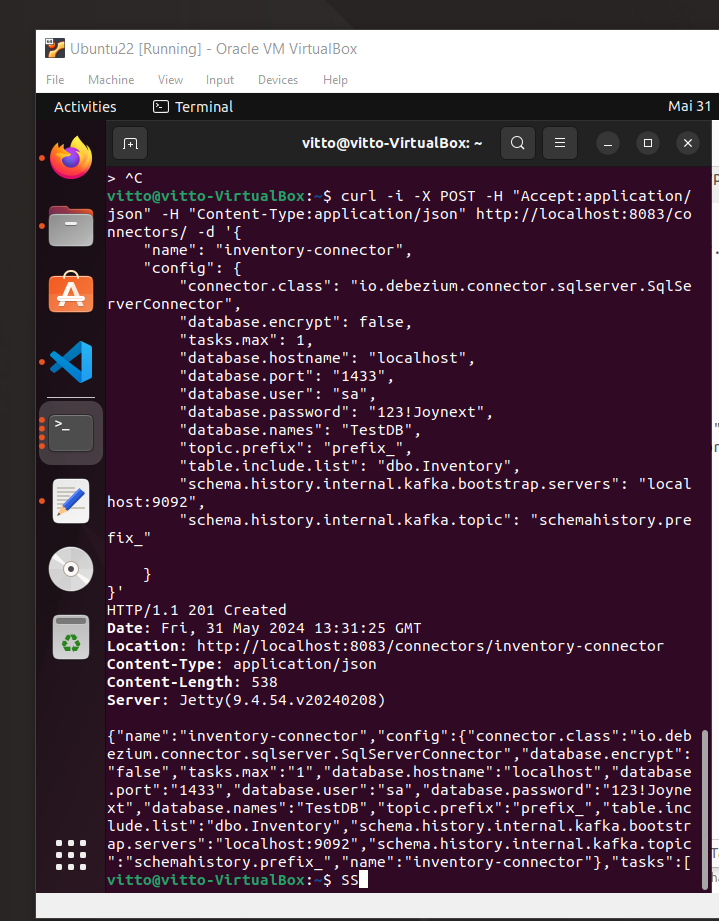|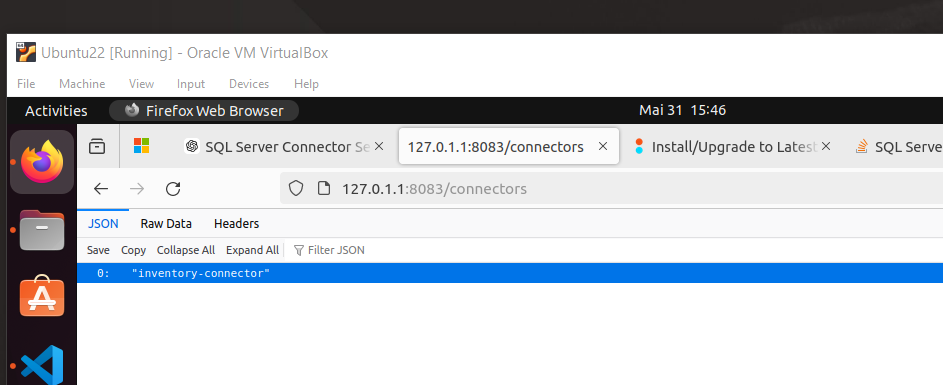 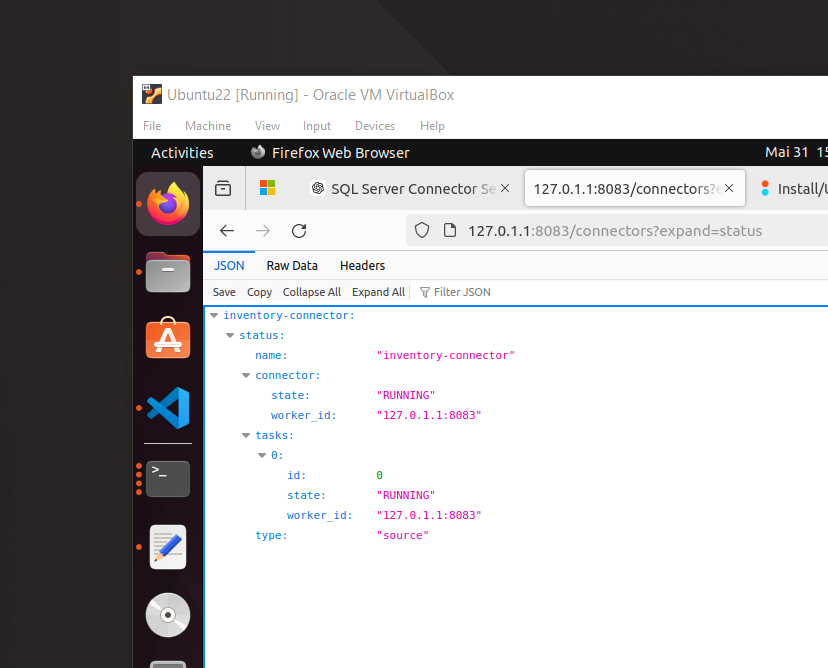|

> /connectors?expand=info


|Information About the Connector||
|---|---|
|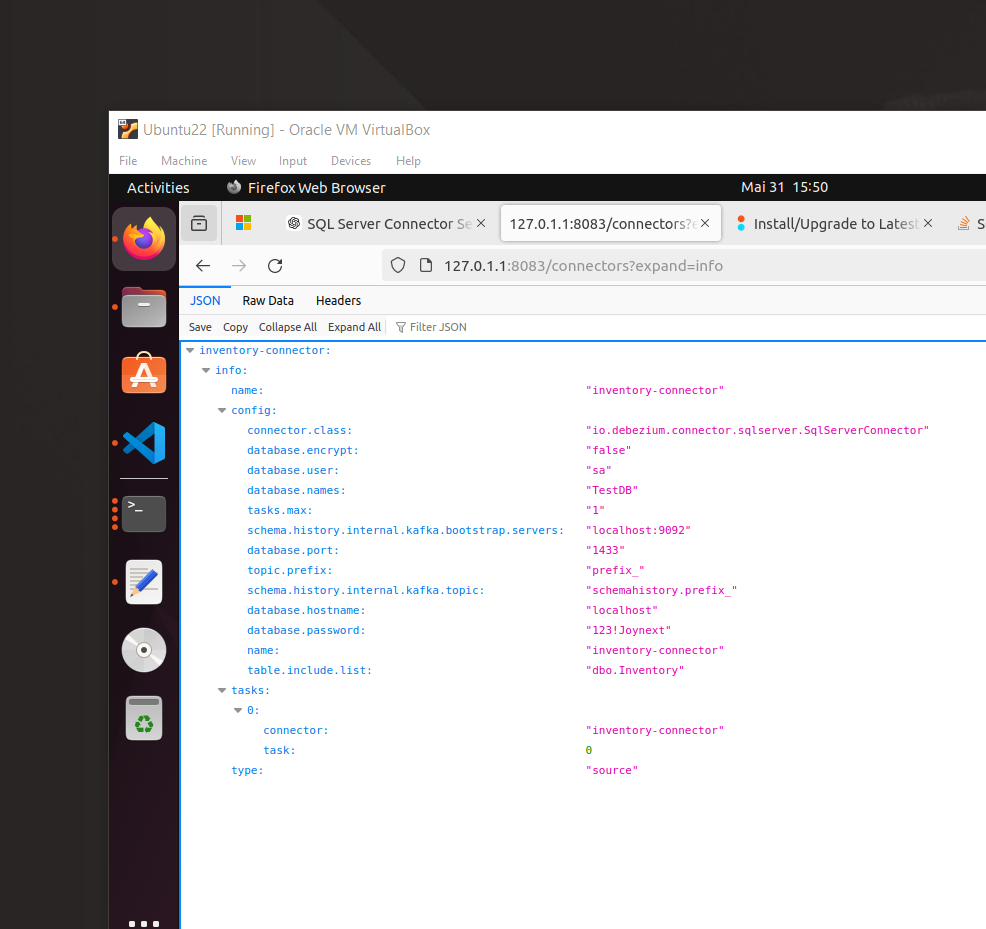||

### More API commands

Checking the connectors:
```shell
$ curl -XGET http://localhost:8083/connectors
```
Retrieves additional state information for each of the connectors and its tasks
```shell
$ curl -XGET http://localhost:8083/connectors?expand=status
```
Returns the metadata of each of the connectors such as the configuration, task information and type of connector
```shell
$ curl -XGET http://localhost:8083/connectors?expand=info
```
Get details about a particular connector: 
```shell
$ curl -XGET http://localhost:8083/connectors/<connector-name>
```
Deleting a connector:
```shell
$ curl -XDELETE http://localhost:8083/connectors/<connector-name>
```

# Hands-On: See in Kafka the CDC 
---

List all the kafka topics on your server
```shell
kafka-topics --list --bootstrap-server localhost:9092
```

> look for the ones that are for your Debezium Connector
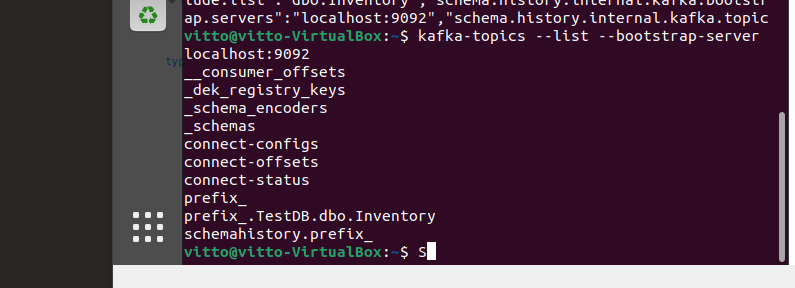

> the `.Inventory` is our table, now you can use a kafka consumer console to see the data

|Command|Result|
|---|---|
|```shell kafka-console-consumer --bootstrap-server localhost:9092 --topic prefix_.TestDB.dbo.Inventory --from-beginning``` |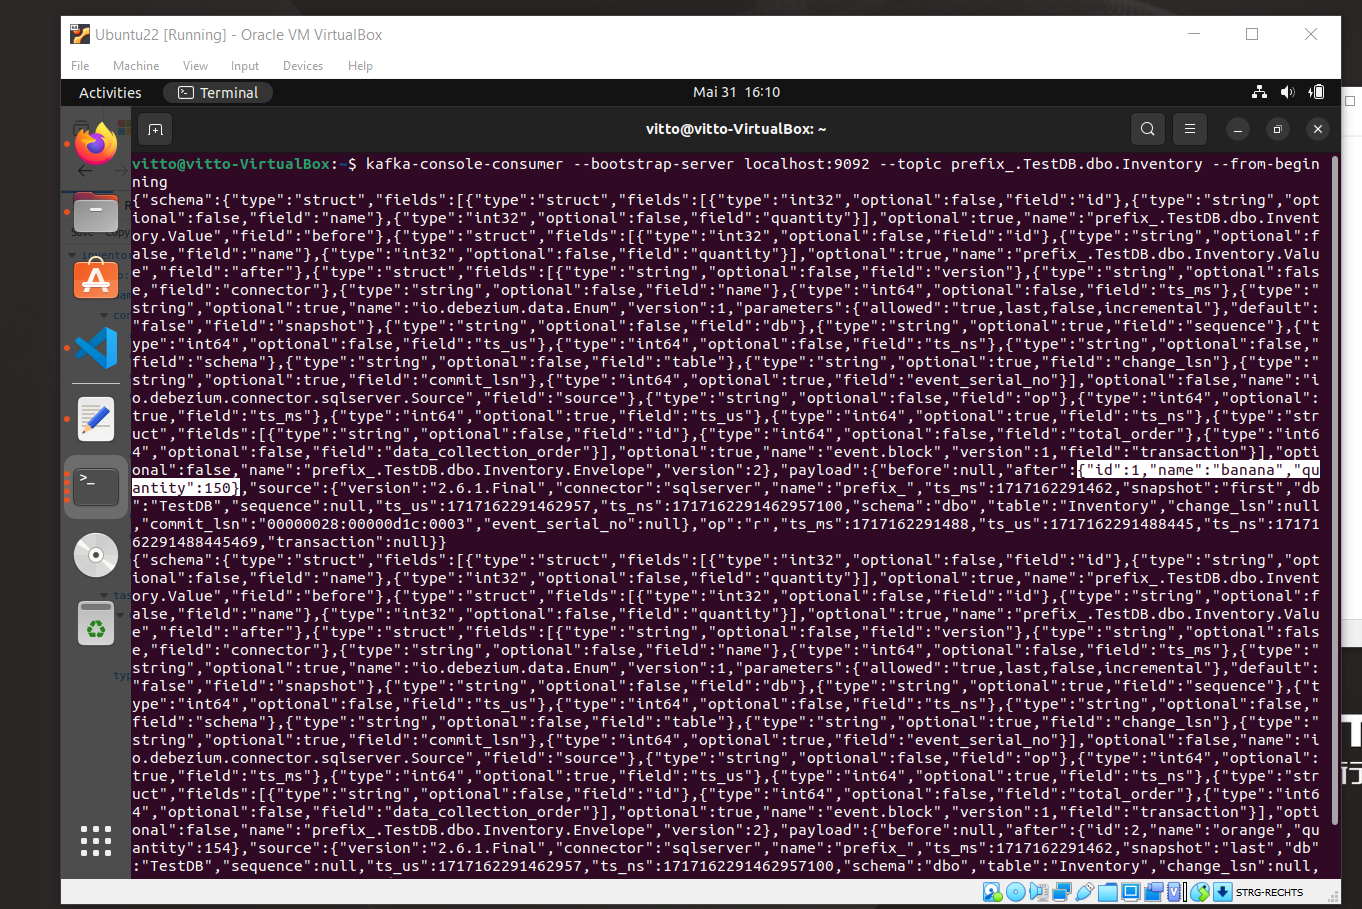|

> The data is there but it is a mess of other data too

### Lets insert a new row and see if it propagates
|SQLCMD|The Kafka Consumer Console|
|---|---|
|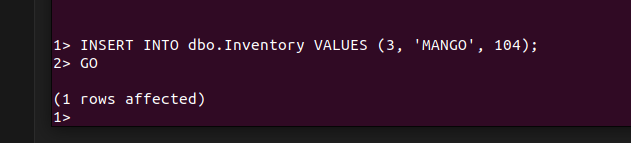|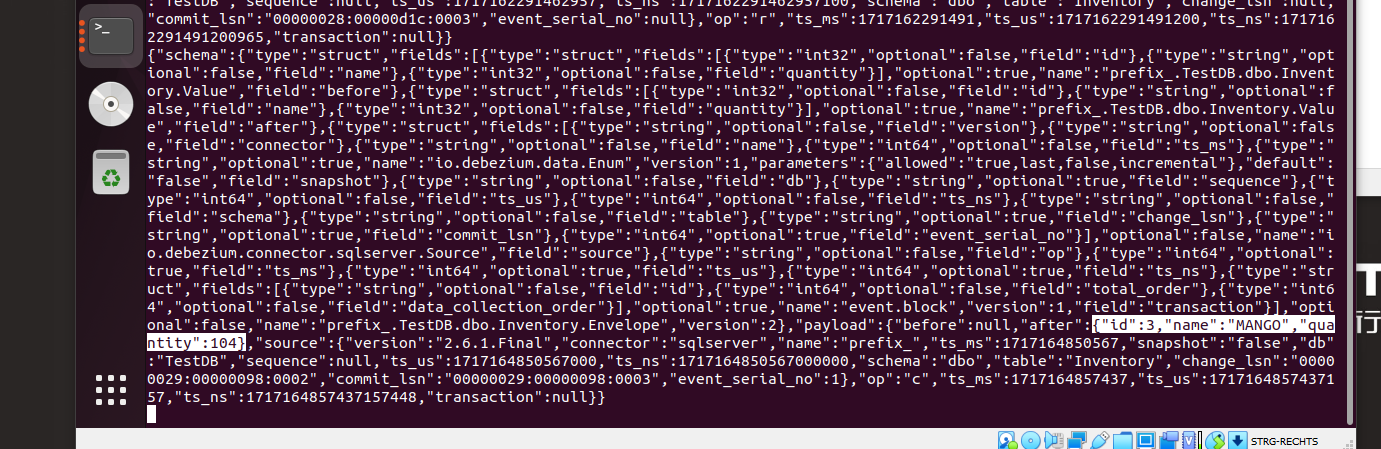|

sa <br>
123!Joynext